In [3]:
import run
import measure

import pickle
from scipy import stats
import numpy as np
import pandas as pd
import glob

import seaborn as sns
import matplotlib.pyplot as plt

#Supress default INFO logging

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

import sys
sys.path.append('../../')
sys.path.append('../')


import german.default as german_default
import german.questions as german_questions
import german.parameters as german_parameters
import german.valid as german_valid

import ipums.default as ipums_default
import ipums.valid as ipums_valid
import ipums.questions as ipums_questions
import ipums.parameters as ipums_parameters

In [101]:
sns.set(style='whitegrid', font_scale=1.2)

In [67]:
df = []
for default, qprefix, dataset, questions, qtypes in zip(
    [ipums_default.default, german_default.default], 
    ['I', 'G'],
    ['IPUMS-CPS', 'German-Credit'],
    [ipums_valid.questions, german_valid.questions],
    [ipums_valid.qtype, german_valid.qtype],
):
    for i, (question, qtype) in enumerate(zip(questions, qtypes)):
        controls = []
        for rho in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]:
            controls += [question + [('rho_query', rho)]]
        default = {**run.DEFAULT, **default} 
        for setting_change in controls:
            setting = default.copy()
            for key, value in setting_change: 
                setting[key] = value
            hashed = run.hash_setting(setting)
            fprefix = f'./intermediates/{hashed}'
            acc = []
            for fname in glob.glob(fprefix + '*'):
                with open(fname, 'rb') as finp:
                    intermediates = pickle.load(finp)
    #             print(intermediates['QuestionCI'])
                if intermediates['QuestionCI'][0] < 0:
                    acc.append(0)
                else:
                    acc.append(1)
            acc = np.mean(acc)
#             print(setting['rho_query'], setting['attr_group'], setting['group_a'], setting['group_b'], acc)
            df.append({
                'Privacy Budget of Query': setting['rho_query'],
                'attr_group': setting['attr_group'],
                'group_a': setting['group_a'],
                'group_b': setting['group_b'],
                'Accuracy': acc,
                'dataset': dataset,
                'qtype': qtype,
                'qindex': f'{qprefix}{i+1}'
            })
df = pd.DataFrame(df)

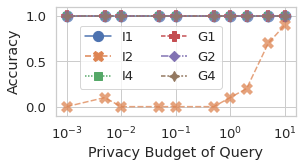

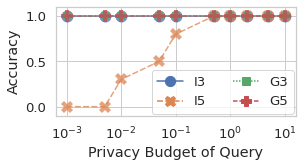

In [66]:
for qtype in ['valid', 'invalid']:
    fig, ax = plt.subplots(figsize=(4.3, 2))
    sns.lineplot(data=df.query(f'qtype == "{qtype}"'), 
                 x='Privacy Budget of Query', y='Accuracy', 
                 hue = 'qindex',
                 style='qindex', 
                 ax = ax,
                 alpha = 0.75,
                 markersize = 12,
                 markeredgewidth = 0,
                 markers=True, 
                 dashes=True)
    lgnd = ax.legend(ncol=2,markerscale=10)
#     for handle in lgnd.legendHandles:
#         print(type(handle))
#         handle.set_sizes([6.0])
    if qtype == 'valid':
        ax.legend(ncol=2, loc=(0.1, 0.25),markerscale=1.7)
    if qtype == 'invalid':
        ax.legend(ncol=2, loc=(0.4, 0.02),markerscale=1.7)
    ax.set_xscale('log')
    ax.set_ylim(-0.1, 1.1)
    fig.savefig(f'./plots/Noise-{qtype}.pdf', bbox_inches='tight')

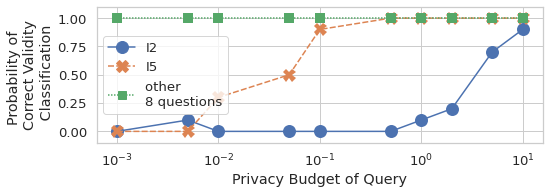

In [115]:
fig, ax = plt.subplots(figsize=(8, 2.5))
data = df.query('qindex in ["I2", "I5", "I3"]').copy()
data.loc[data['qindex'] == "I3", 'qindex'] = 'other \n8 questions'
data = data.sort_values('qindex')
data['Probability of Correct Suggestion'] = data['Accuracy']
# data = df
sns.lineplot(data=data, 
             x='Privacy Budget of Query', y='Accuracy', 
             hue = 'qindex',
             style='qindex', 
             ax = ax,
             alpha = 1.0,
             markersize = 13,
             markeredgewidth = 0,
             markers=True, 
             dashes=True)
# ax.legend(ncol=5, loc=(-0.12, 1),markerscale=1.7)
ax.legend(ncol=1, markerscale=2)
ax.set_xscale('log')
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel('Probability of \nCorrect Validity\n Classification')
fig.savefig(f'./plots/Noise-Quant.pdf', bbox_inches='tight')